In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats

In [ ]:
import pickle

# load
fn_load = 'J_Dataset_1101_0630_outlier_3sig'

with open(fn_load + '.pickle', 'rb') as f:
    data = pickle.load(f)

fn = data['fn']
damage_ind = data['damage_ind']
df1, df3 = data['data'][0], data['data'][1]

In [19]:
X0 = synthetic_data(4, 700)

IDX_NORMAL = 600
IDX_NORMAL_MODEL = 500
SIZE_ALL = X0.shape[0]

for ind in range(X0.shape[1]):
    X0[IDX_NORMAL::, ind] = X0[IDX_NORMAL::, ind] + np.random.normal(0.5, 0.001, (100, 1)).reshape(1, -1)

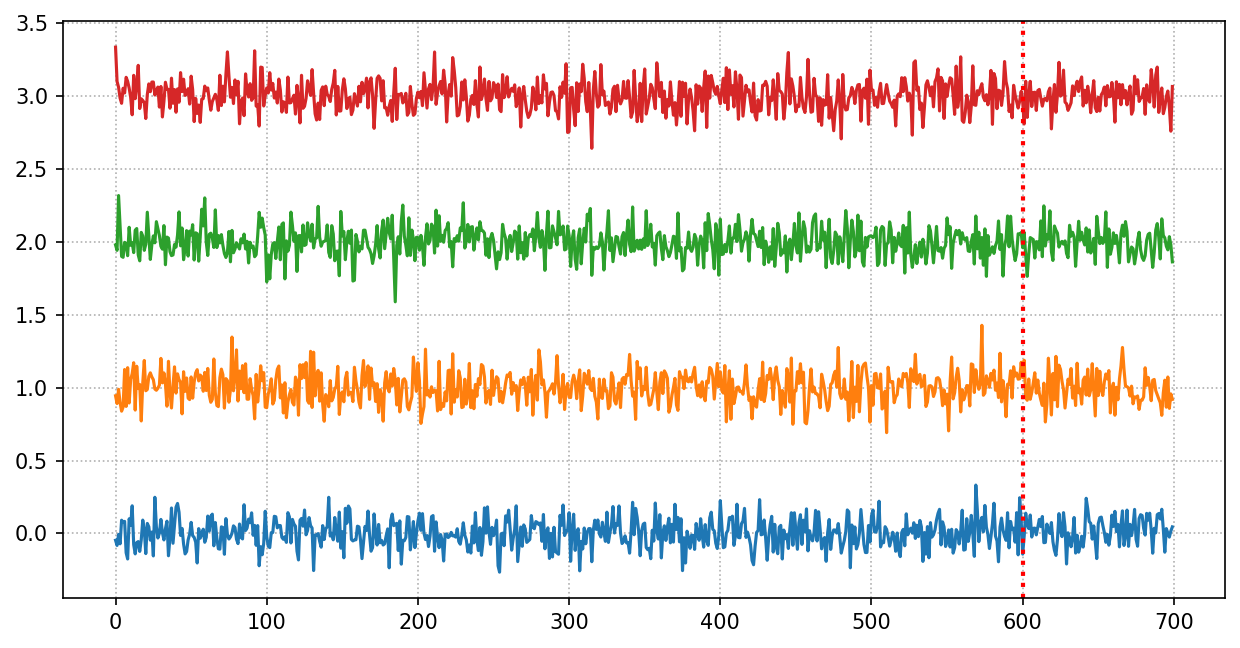

In [20]:
plt.figure(figsize = (10, 5), dpi =150)
plt.plot(X0)
plt.axvline(IDX_NORMAL, linestyle = ':', color = 'red', linewidth = 2)
plt.grid(linestyle = ':')
plt.show()

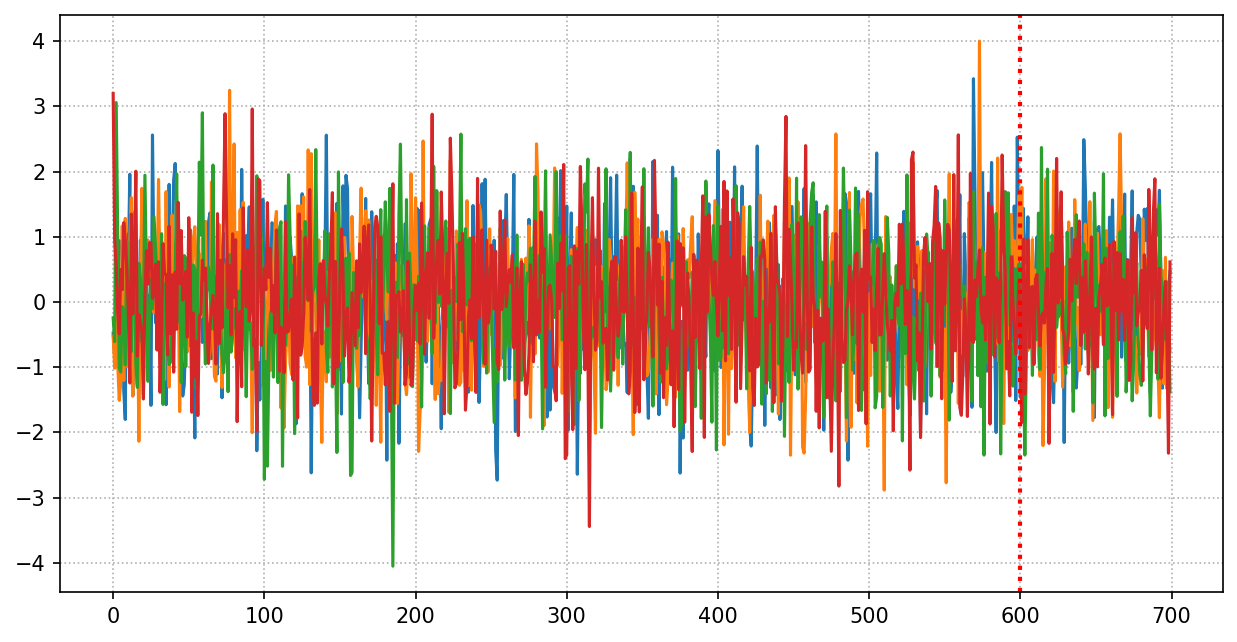

In [21]:
# Define standardizer (scaling)
scaler = StandardScaler()

Xtrain = scaler.fit_transform(X0[0:IDX_NORMAL_MODEL,:])

# Get samples from baseline (Normal data)
Xvalid = scaler.transform(X0[IDX_NORMAL_MODEL::,:])
X_scaled = np.concatenate([Xtrain, Xvalid])

plt.figure(figsize = (10, 5), dpi =150)
plt.plot(X_scaled)
plt.axvline(600, linestyle = ':', color = 'red', linewidth = 2)
plt.grid(linestyle = ':')
plt.show()

In [22]:
# scaler
# Xtrain
# Xvalid
# X_scaled

#### **Run PCA**

In [23]:
def perform_PCA_given_data(X):
    '''
        - Input
            X : Normalzied training samples [N(# samples)-by-f(# features)]

        - Output
            pca: fitted PCA model
            explVar: exaplined variance for PCs
            V: principal compoent vectors
            n_comp: # retained PCs
    '''
    from sklearn.decomposition import PCA
    pca = PCA().fit(X)

    # Explained variance of each features for PCA
    S = pca.explained_variance_
    
    # Retained PCs
    V = pca.components_

    return pca, S, V

pca, S, V = perform_PCA_given_data(Xtrain)


#### **Plot exlained PCs**

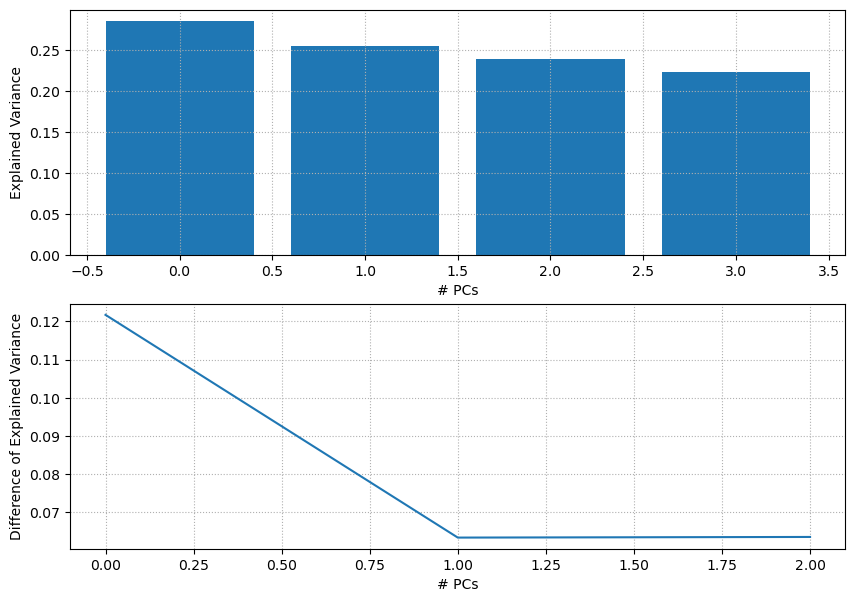

In [24]:
fig, ax = plt.subplots(2, 1, figsize = (10, 7))
# ax[0].bar(np.arange(0, S.shape[0]), S)
ax[0].bar(np.arange(0, S.shape[0]), S / sum(S))
ax[0].set_xlabel('# PCs')
ax[0].set_ylabel('Explained Variance')
ax[0].grid(linestyle = ':')


ax[1].plot(np.arange(0, S.shape[0]-1), np.abs(np.diff(S)))
# ax[1].plot(n_comp, np.abs(np.diff(S))[n_comp], 'bo', label = 'Optimal # PC')
ax[1].set_xlabel('# PCs')
ax[1].set_ylabel('Difference of Explained Variance')
ax[1].grid(linestyle = ':')
# ax[1].legend()
plt.show()

#### **Evaluation Step (Monitoring Phase)**

In [25]:
alpha = 0.95
n_comp = 1

# Select optimal # of PCs: eigengap technique
# % ref.1) The rotation of eigenvectors by a perturbation (1970)
# % ref.2) Adaptive data-derived anomaly detection in the activated... (2016)
n_comp = np.argmax(np.abs(np.diff(S)))
n_comp

0

In [26]:
X = X_scaled
X_proj = np.matmul(X, V[:n_comp].T) 

In [27]:
try:
    plt.plot(X_proj[:, 0], X_proj[:, 1], 'b.')
    plt.show()
except:
    print('')

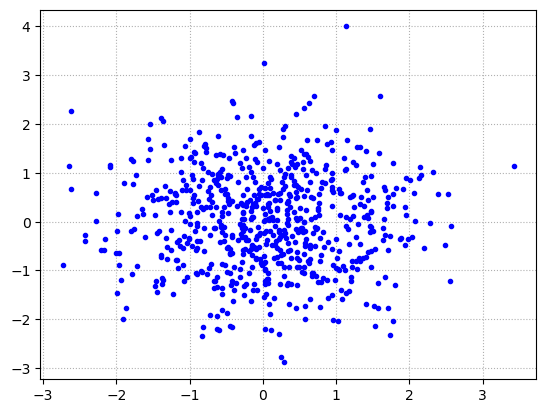

In [28]:
plt.plot(X[:, 0], X[:, 1], 'b.')
plt.grid(linestyle = ':')
plt.show()

#### **1. Q-Statistic**
Q- residual indicates how well each sample conforms to the PCA model. 
- It is a measure of the difference, or residual between a sample and its projection into the principal components retained in the model.

$$
    Q(X, P_{1:r}) = X(I - P_{1:r}P_{1:r}^T)X^T = \| X - \hat{X} \|^2
$$

where $\hat{X} = P_{1:r} X$
- X: Normalized X
- P: Principal component (PC) vectors
- r: # of retained PCs

*Compute Q-Statistics*

In [29]:
Q = np.sqrt(np.sum(
    (X - np.matmul(np.matmul(X, V[:n_comp].T), V[:n_comp]))**2
    , axis = 1))

*Compute threshold of Q-Statistics*

$$
    Q_{alpha} = \frac{\theta_2}{2 \theta_1}\chi_{\alpha}^2(h)
$$

where 
- $\theta_1$: sample mean
- $\theta_2$: sample variance
- $\chi_{\alpha}^2(h)$: chi-squared distribution with $h$ degree of freedom and the significance level $\alpha$
- $h = \frac{2\theta_1^2}{\theta_2}$

> Note it is based on normality assumption on Q-statistics

In [30]:
from scipy.stats.distributions import chi2

theta1 = np.mean(Q)
theta2 = np.var(Q)
h = 2 * (theta1 ** 2) / theta2
chi_h = chi2.ppf(alpha, df=h)
Qlimit = theta2/(2*theta1) * chi_h

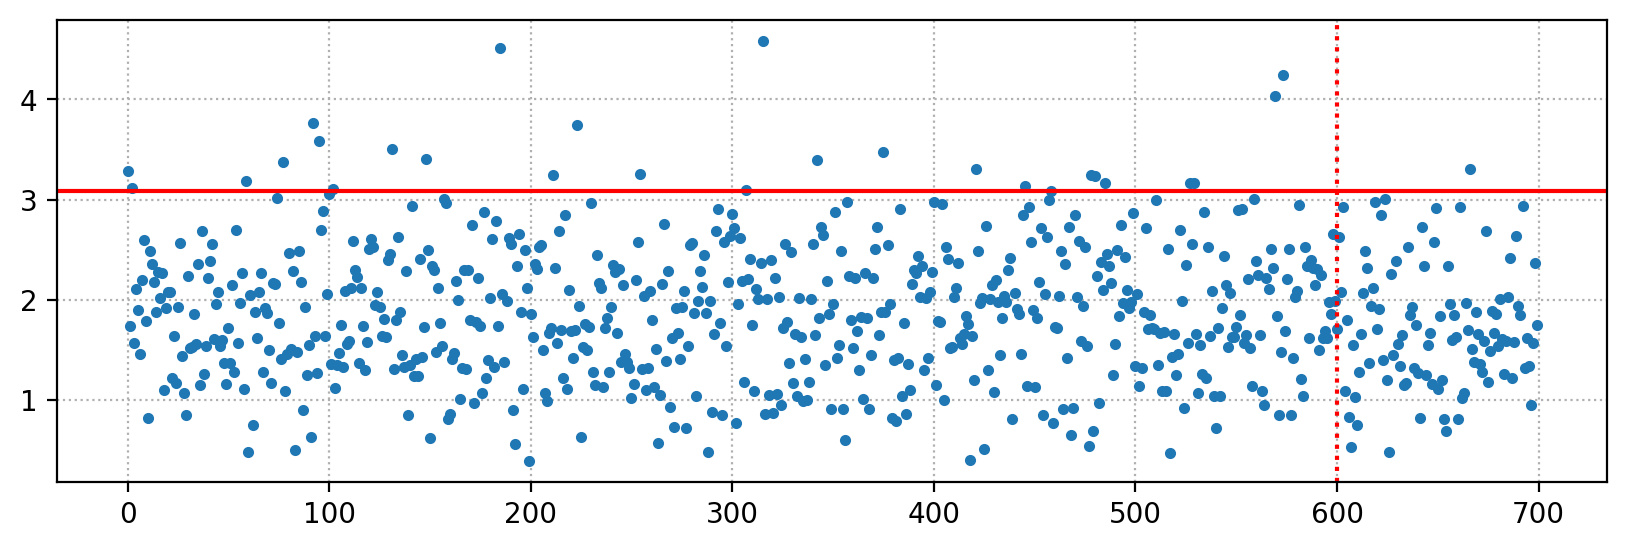

In [31]:
plt.figure(figsize = (10, 3), dpi = 200)
plt.plot(Q, '.')
plt.axhline(Qlimit, color = 'r', linestyle = '-')
plt.axvline(IDX_NORMAL, color = 'r', linestyle = ':')
plt.grid(linestyle = ':')
plt.show()

#### **Hotelling’s T2 Statistic**
Now to calculate the T2 statistic, just transform each example.

We calculate the SVD decomposition of the covariance matrix, and with that we can use the equation below to calculate the z_score to each example in our dataset

$$
    z = \Lambda_{1:r}^{-1/2}P_{1:r}^TX, \\
    \text{ } \\
    T^2 =z^Tz
$$

*Compute T2-Statistics*

In [32]:
S_inverse = np.mat(np.diag(S[:n_comp])).I
T2 = []
for i in range(X_proj.shape[0]):
    value = np.matmul(np.matmul(X_proj[i], S_inverse), X_proj[i])
    T2.append(float(value))

*Compute threshold of T2-Statistics*

<center> <p>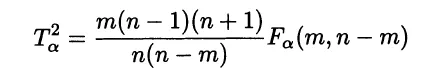</p> </center>

In [33]:
Ntrain, dim = Xtrain.shape[0], V.shape[1]
t2limit = ((dim*(Ntrain-1))/ (Ntrain - dim)) * scipy.stats.f.ppf(q=alpha, dfn=dim, dfd=496)
dd_upper = np.zeros((SIZE_ALL, 1))
dd_upper[:] = t2limit

*Plot result*

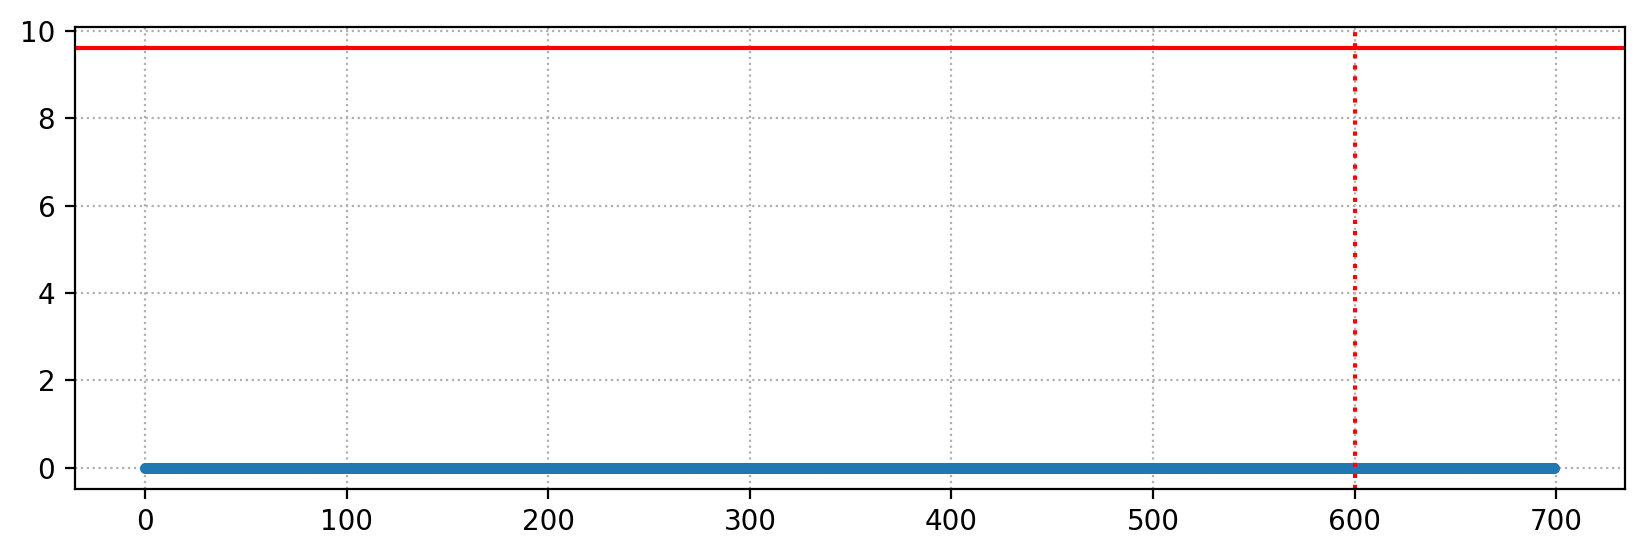

In [34]:
plt.figure(figsize = (10, 3), dpi = 200)
plt.plot(T2, '.')
plt.axhline(t2limit, color = 'r', linestyle = '-')
plt.axvline(IDX_NORMAL, color = 'r', linestyle = ':')
plt.grid(linestyle = ':')
plt.show()

- Comformal prediction => stoppting criteria => based on significance level (alpha)